<a href="https://colab.research.google.com/github/layely/DeepLearning-Course-UdeM/blob/master/TP1_own_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation


## Connect to Google Drive


In [0]:
# Code to read csv file into Colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Download dataset (zip file)

In [0]:
# Download dataset (chest_xray.zip)

# Gdrive link of the dataset 
link = 'https://drive.google.com/open?id=1UmA1WKqZfOkN0EP5lno8h9aAbFDIZ-hQ'
  
_, id = link.split('=')

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('chest_xray.zip')

## Extract dataset archive

In [0]:
# Extract dataset archive

import os
import zipfile

try:
  !rm -r chest_xray
except:
  pass

archive = zipfile.ZipFile('chest_xray.zip', 'r')
archive.extractall()


if os.path.isdir("chest_xray"):
  print("archive successfully extracted")
else:
  print("Can't extract archive")
  


archive successfully extracted


## Re-balance train/val distribution
**To run only once!!!**

At this point, the validation set consist of only 16 images. In order to improve the robustness of the model, we copy from the training 2x216 images to increase the proportion of images in the validation set.


In [0]:

# By default we have only 16 images in the validation folder
# To rebalance the distribution train/val, we copy a subset from
# train folder to val folder

!mv `ls -d chest_xray/train/NORMAL/* | head -184` chest_xray/val/NORMAL/ #112
!mv `ls -d chest_xray/train/PNEUMONIA/* | head -184` chest_xray/val/PNEUMONIA/
#!ls chest_xray/train/PNEUMONIA | head -10

## Load dataset with ImageGenerators

We load the dataset via ImageDataGenerator provided in Keras. We also applied some augmentation on the training and validation set which slightly improved our models performance during testing. The transformations includes random horizontal flipping (for both training et validation) and small rotation (<=10°) and zoom (<=0.1) only on the training set.

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, \
  img_to_array, load_img


def getImageGenerators(target_size=(224, 224), batch_size=16):
  train_datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, horizontal_flip=True, rescale=1./255)
  val_datagen = ImageDataGenerator(horizontal_flip=True, rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(
      directory=r"./chest_xray/train/",
      target_size=target_size,
      color_mode="rgb",
      batch_size=batch_size,
      class_mode="categorical",
      shuffle=True,
      seed=42
  )

  val_generator = val_datagen.flow_from_directory(
      directory=r"./chest_xray/val/",
      target_size=target_size,
      color_mode="rgb",
      batch_size=batch_size,
      class_mode="categorical",
      shuffle=True,
      seed=42
  )

  test_generator = test_datagen.flow_from_directory(
      directory=r"./chest_xray/test/",
      target_size=target_size,
      color_mode="rgb",
      batch_size=1,
      class_mode='categorical',
      shuffle=False,
      seed=42
  )

  return train_generator, val_generator, test_generator 

# Model definition

Here we define our model architecture from the scratch which consist of 4 conv layers (+relu) followed each by a max pooling layer. After the 4th pooling layer we attach global average layer. This first part can be called our feature extractor and is followed by 2 fully connected layers topped with a softmax function standing as our classifier. We apply a 0.5 dropout before each FC layer. The network totals only 110,882 parameters compared to +2,3M for MobileNetV2 and 7,1M for DenseNet.


In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Cropping2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def getModel(input_shape, loss, optimizer, activation):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=input_shape))
  model.add(Activation(activation))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3)))
  model.add(Activation(activation))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation(activation))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(128, (3, 3)))
  model.add(Activation(activation))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(GlobalAveragePooling2D())
  
  #model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors
  model.add(Dropout(0.5))
  model.add(Dense(64))
  model.add(Activation(activation))
  model.add(Dropout(0.5))
  model.add(Dense(2))
  model.add(Activation('softmax'))

  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  return model

# Visualize model
model = getModel(input_shape=(224,224,3), loss="categorical_crossentropy", optimizer="rmsprop", activation="relu")
model.summary()
print("Number of layers:", len(model.layers))
"""
# For a more fancy visualization
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

img = mpimg.imread('model_plot.png')
plt.figure(figsize = (10,30))
plt.imshow(img, interpolation='nearest')
"""

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_13 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_14 (Activation)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 52, 52, 64)        18496     
__________

"\n# For a more fancy visualization\nplot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)\n\nimg = mpimg.imread('model_plot.png')\nplt.figure(figsize = (10,30))\nplt.imshow(img, interpolation='nearest')\n"

# Training

## Define Callbacks

Here we define two callbacks: 
* `reduce_lr_callback` which reduces the learning rate by a factor of 0.2 when the validation loss is almost static after 5 epochs.
* `checkpoint_acc_callback` which save the entire model after each epoch where we get a better validation accuracy.

In [0]:
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


SAVED_MODEL_PATH = "best_model_acc_ownmodel.h5"
checkpoint_acc_callback = ModelCheckpoint(SAVED_WEIGHT_PATH, monitor='val_acc', verbose=0, save_best_only=True, 
                                save_weights_only=False, mode='max', period=1)

## Optimization
In this subsection, we just defined various configurations of optimizers, tested each of them and found out that Adam with a learning rate of 0.001 and no decay gives usually the best results during our experimentations (perfomed outside collabs as it very hard training on it for many hours)

In [0]:
from keras import optimizers

# List useful only during parameter optimization
optimizers_list = [
    # SGD
    optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False),#1
    optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=True),
    optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
    optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=True),
    optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
    optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
    optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True),
    # Adagrad
    optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0),#8
    optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=1e-6),
    optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0),
    optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=1e-6),
    optimizers.Adagrad(lr=0.001, epsilon=1e-08, decay=0.0),
    optimizers.Adagrad(lr=0.001, epsilon=1e-08, decay=1e-6),
    # AdaDelta
    optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0), #14
    optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=1e-6),
    optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=1e-08, decay=0.0),
    optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=1e-08, decay=1e-6),
    optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=1e-08, decay=0.0),
    optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=1e-08, decay=1e-6),
    optimizers.Adadelta(lr=0.001, rho=0.95, epsilon=1e-08, decay=0.0),
    optimizers.Adadelta(lr=0.001, rho=0.95, epsilon=1e-08, decay=1e-6),
    
    # RMSprop
    optimizers.RMSprop(lr=0.1, rho=0.9, epsilon=1e-08, decay=0.0),#22
    optimizers.RMSprop(lr=0.1, rho=0.9, epsilon=1e-08, decay=1e-6),
    optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0),
    optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=1e-6),
    optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
    optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=1e-6),
    
    # Adam
    optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),#28
    optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6),
    optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
    optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6),
    optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), # Gives the best results
    optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6),
    
    # Adam amsgrad=True
    optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=True),#34
    optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6, amsgrad=True),
    optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=True),
    optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6, amsgrad=True),
    optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=True),
    optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6, amsgrad=True)
                  ]

## Init model parameters

In this subsections we initialize the training parameters. We use Cross-Entropy as our loss function and Adam with a learning rate of 0.001 as optimizer. We also uses a batch size of 16 during training and our network takes inputs with shape 224x224x3. Finally, our sets are organised as follow: 4784 images for training, 448 for validation and 624 for test.

In [0]:
from keras import optimizers

# Set training hyperparameters
INPUT_WIDTH = 224
INPUT_HEIGHT = 224
NUM_EPOCHS = 100

loss = "categorical_crossentropy"
optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
activation = "relu"

# Since we have 3x more images for Pneunomia,
# weigths the loss to focus more on classifying
# correctly the normal chests.
class_weight = [0.3, 0.1]

model = getModel(input_shape=(INPUT_WIDTH, INPUT_HEIGHT, 3), loss=loss,
                 optimizer=optimizer, activation=activation)

train_gen, val_gen, test_gen = getImageGenerators(target_size=(INPUT_WIDTH, INPUT_HEIGHT), 
                                                 batch_size=16)

print(train_gen.classes)

# Number of steps (for train and val) per epoch during train
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_val = (val_gen.n // val_gen.batch_size)
if step_size_val == 0:
  step_size_val = 1

Found 4848 images belonging to 2 classes.
Found 384 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
[0 0 0 ... 1 1 1]


## Fit Models


In [0]:
!ls

In [0]:
# Run training
history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=step_size_train,
                    validation_data=val_gen,
                    validation_steps=step_size_val,
                    use_multiprocessing=True,
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    class_weight=class_weight,
                    shuffle=True,
                    callbacks=[checkpoint_acc_callback, reduce_lr_callback]
)


Epoch 1/100
303/303 [==============================] - 403s 1s/step - loss: 0.3900 - acc: 0.8238 - val_loss: 0.5466 - val_acc: 0.8203
Epoch 2/100
303/303 [==============================] - 370s 1s/step - loss: 0.3382 - acc: 0.8535 - val_loss: 0.3898 - val_acc: 0.8542
Epoch 3/100
303/303 [==============================] - 353s 1s/step - loss: 0.3054 - acc: 0.8731 - val_loss: 0.3995 - val_acc: 0.8411
Epoch 4/100
303/303 [==============================] - 346s 1s/step - loss: 0.2926 - acc: 0.8777 - val_loss: 0.3599 - val_acc: 0.8698
Epoch 5/100
303/303 [==============================] - 350s 1s/step - loss: 0.2730 - acc: 0.8824 - val_loss: 0.2982 - val_acc: 0.8724
Epoch 6/100
303/303 [==============================] - 348s 1s/step - loss: 0.2549 - acc: 0.9002 - val_loss: 0.4313 - val_acc: 0.8073
Epoch 7/100
303/303 [==============================] - 360s 1s/step - loss: 0.2479 - acc: 0.9008 - val_loss: 0.2455 - val_acc: 0.9010
Epoch 8/100
303/303 [==============================] - 374s 1s

## Learning curves
We run the training on 100 epochs and were able to get training and validation accuracy above 95%. Note that without dropout and data augmentation, training performance improves but inference on test data will decrease considerably (~10%). It can be noted that the validation loss here is more stable in comparison with the DenseNet model. After 80 epoch, the loss slightly decreased and it can be infered that we were getting close to convergence.

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


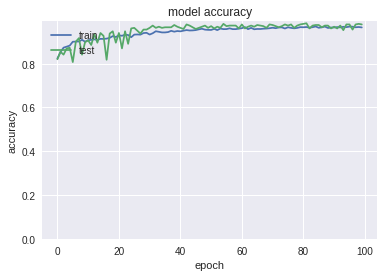

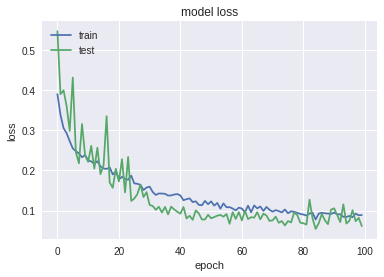

In [0]:
import matplotlib.pyplot as plt

print(history.history.keys())

# Plot curve for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(bottom=0)
plt.show()

# Plot curve for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model evaluation

## Acuracy and Loss scores

The model performed an **accuracy of 83.97%** on the testing set. Considering the high performence during training (+97% val accuracy), we can say that the model is relatively bad at generalizing. 

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from keras.models import load_model

# delete model
del model

# Load best model
model = load_model (SAVED_MODEL_PATH)

loss, accuracy = model.evaluate_generator(generator=test_gen, steps=test_gen.n)

print("Loss: {}    ---    Accuracy: {}%".format(round(loss, 3), round(accuracy * 100, 2)))

Loss: 0.595    ---    Accuracy: 82.85%


In [0]:
!ls -l --block-size=M

## Confusion Matrix
The confusion matrice shows that the model misses just a few number of pneumonia cases (~1,54%) which is a good thing if we don't want to tolerate a high rate of false negatives. Though this comes with a downside because we have to many xray scan wrongly classified as  pneumonia (~44%).

Number of predicted normal cases: 137


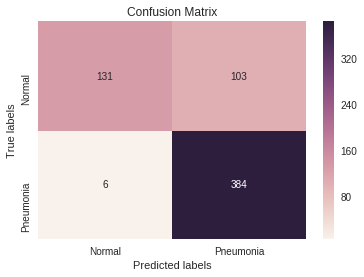

In [0]:
# Install seaborn, for a fancy (heated) confusion matrix
!pip install seaborn
import seaborn as sns

Y_pred = model.predict_generator(generator=test_gen, steps=test_gen.n)

y_pred = np.argmax(Y_pred, axis=1)
y_true = test_gen.classes # Array of true labels

pred_normal = [i for i in y_pred if i == 0]
print("Number of predicted normal cases:", len(pred_normal))

cm = confusion_matrix(y_true, y_pred)  

# Plot confusion matrix

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia']); ax.yaxis.set_ticklabels(['Pneumonia', 'Normal']);

## Precision, Recall and F1score 

In [0]:
print('Classification Report')
target_names = ['NORMAL', 'PNEUNOMIA']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.96      0.56      0.71       234
   PNEUNOMIA       0.79      0.98      0.88       390

   micro avg       0.83      0.83      0.83       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.83      0.81       624



## ROC curve
The area under the curve is 95% which is the best among all the models we trained. Indeed the curve shows that we can reach a detection accuracy of ~90% on true positive while keeping the rate of false positives as low as ~10%.

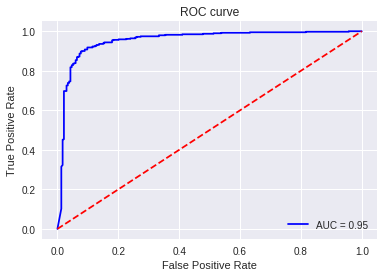

In [0]:
# Predicted probability scores for pneumnia (positives)
pneumnia_scores = Y_pred[:, 1]

# y_true defined in "Confusion Matrix" section represent
# the labels (observed value)
fpr, tpr, thresholds = roc_curve(y_true, pneumnia_scores)
roc_auc = auc(fpr, tpr)

# PLot the roc curve
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Exemples of good and bad predictions

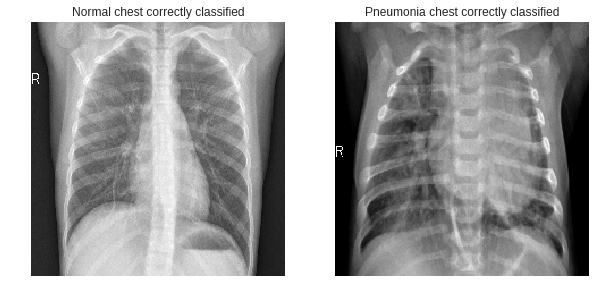

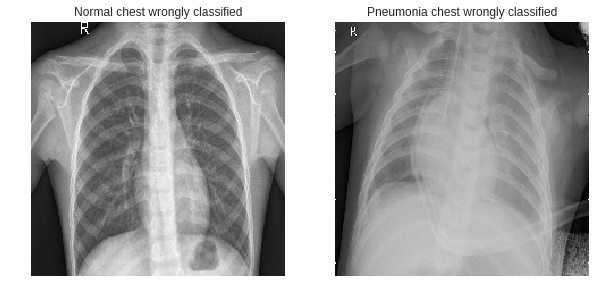

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [0]:
""" Get image at index specified from the test set """
def getTestImageFromIndex(index):
  return test_gen.__getitem__(index)[0]

def show_images_side_by_side(img1, img2, title1, title2):
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,10))
  ax1.imshow(img1.reshape(INPUT_WIDTH, INPUT_HEIGHT, 3))
  ax2.imshow(img2.reshape(INPUT_WIDTH, INPUT_HEIGHT, 3))
  ax1.set_title(title1)
  ax2.set_title(title2) 
  ax1.set_axis_off()
  ax2.set_axis_off()
  plt.show()

# Get one indexe of correct negative (normal chest) and correct positive (pneumonia) prediction
correct_pred_of_normal_chest = [i for i, x in enumerate(y_true) if x == 0 and x == y_pred[i]][0]
correct_pred_of_pneumonia_chest = [i for i, x in enumerate(y_true) if x == 1 and x == y_pred[i]][0]

# Get one indexe of wrong negative (normal chest) and wribg positive (pneumonia) prediction
wrong_pred_of_normal_chest = [i for i, x in enumerate(y_true) if x == 0 and x != y_pred[i]][0]

# Currently all Pneumonia are correctly classified due to data unbalance
try:
  wrong_pred_of_pneumonia_chest = [i for i, x in enumerate(y_true) if x == 1 and x != y_pred[i]][0]
  tile4 = "Pneumonia chest wrongly classified"
except:
  # No case of wrongly classified pneumonia
  # We also make sure we do not pick the index of wrong_pred_of_normal_chest
  wrong_pred_of_pneumonia_chest = [i for i, x in enumerate(y_true) if x != y_pred[i] and i != wrong_pred_of_normal_chest][0]
  tile4 = "Another normal chest wrongly classified"
  
correct_pred_normal_chest_img = getTestImageFromIndex(correct_pred_of_normal_chest)
correct_pred_pneumonia_chest_img = getTestImageFromIndex(correct_pred_of_pneumonia_chest)

wrong_pred_normal_chest_img = getTestImageFromIndex(wrong_pred_of_normal_chest)
wrong_pred_pneumonia_chest_img = getTestImageFromIndex(wrong_pred_of_pneumonia_chest)

show_images_side_by_side(correct_pred_normal_chest_img, 
                         correct_pred_pneumonia_chest_img, 
                         "Normal chest correctly classified",
                         "Pneumonia chest correctly classified")

show_images_side_by_side(wrong_pred_normal_chest_img, 
                         wrong_pred_pneumonia_chest_img, 
                         "Normal chest wrongly classified",
                         tile4)

# Show array of true labels and predicted values
print(y_true)
print('---------------------------------------------------------------------')
print(y_pred)


# Save best model in my Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#!ls "/content/drive/My Drive"
TP_DL_dir = "/content/drive/My\ Drive/TP_DL"

BEST_WEIGHTS = (TP_DL_dir + "/own_model_weights.hd5").replace('\ ', ' ')
BEST_MODEL = (TP_DL_dir + "/own_model.hd5").replace('\ ', ' ')

print(BEST_MODEL)

model.save_weights(BEST_WEIGHTS)
model.save(BEST_MODEL)

!ls {TP_DL_dir}

# References
1. https://keras.io/
2. https://scikit-learn.org/stable/documentation.html
3. https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785#answer-48018785
4. https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python?rq=1#answer-38467407